# Analysis file for Ariane quantitative runs
gets data from .nc file into basic plot<br>
based on code from https://github.com/SalishSeaCast/analysis-susan/blob/master/notebooks/Ariane/FluxRobertsBankApr2015-New.ipynb

In [2]:
import cmocean.cm as cm
import glob
from matplotlib.colors import LogNorm, Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

import scipy.interpolate as interp

from salishsea_tools import nc_tools

%matplotlib inline

### get grid info

In [3]:
mymesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdepw_1d)

### Hourly particle crossing, 1 day run

In [4]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/JDF_salish/14sep17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
time1 = mydata.init_t[0]

In [5]:
def get_data(mydata, section, time):
    lons = mydata.final_lon[(mydata.final_section==section) & (mydata.init_t==time)]
    depths = depthf(mydata.final_z[(mydata.final_section==section) & (mydata.init_t==time)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section) & (mydata.init_t==time)]
    return lons, depths, transports

#### SoG3

In [5]:
section = 4

figrid = 266 #fortran igrid
igrid = figrid-1
fmask = mymesh.fmask[0, :, igrid]
tmask = mymesh.tmask[0]
nav_lon = mymesh.nav_lon[igrid]
u_lons = mymesh.glamv[0, igrid]    # note switch to v with the switch from t to f
f_lons = mymesh.glamf[0, igrid]
w_depths = mymesh.gdepw_1d

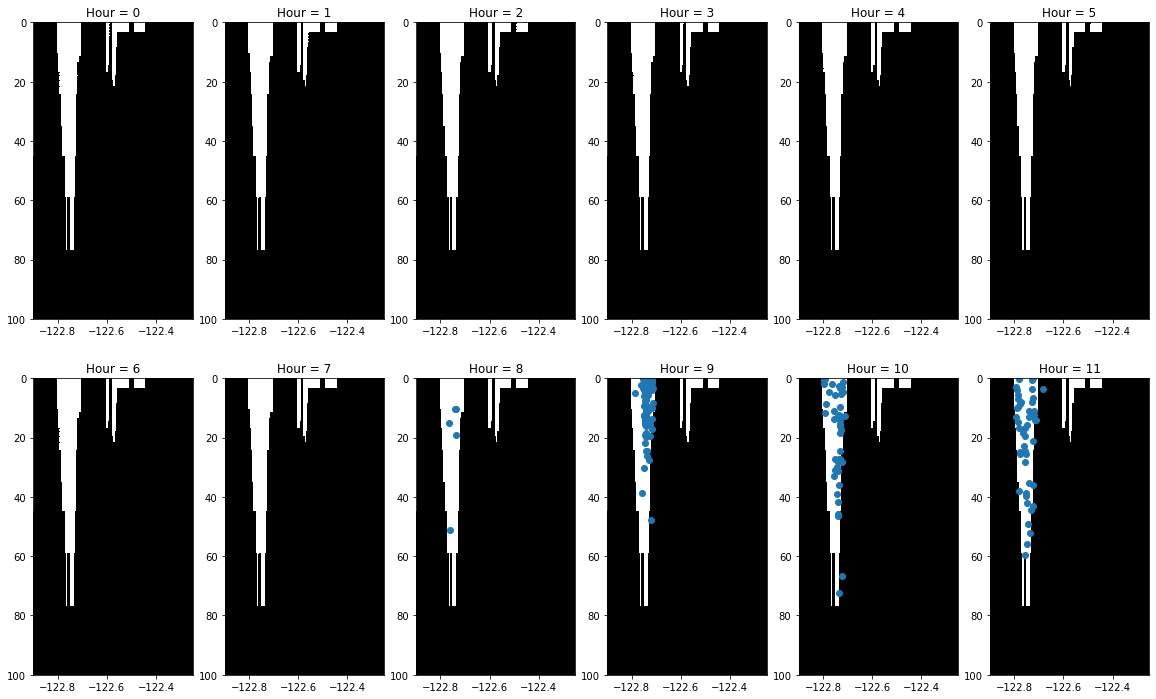

In [6]:

fig, axs = plt.subplots(2, 6, figsize=(20, 12))
x, y = np.meshgrid(u_lons, w_depths)
for hour in range(12):
    ax = axs[int(hour/6), hour-6*int(hour/6)]
    lons, depths, transports = get_data(mydata, section, time1+hour)
    ax.pcolormesh(x, y, fmask, cmap='Greys_r',  shading='auto')
    ax.plot(lons, depths, 'o')
    ax.invert_yaxis()
    ax.set_xlim((-122.9, -122.25))
    ax.set_ylim((100, 0))
    ax.set_title("Hour = "+str(hour))

clearly taking the figrid from sections.txt doesn't QUITE work (especially visible in hour 11 where many of the particles come in at a deph that is ground according to the grid)

### Daily flux, 1 day run

In [6]:
salfile = '/results/SalishSea/nowcast-green.201812/14sep17/SalishSea_1d_20170914_20170914_grid_T.nc'

In [7]:
def draw_patches(fmask, ll, ul, u_lons, w_depths):
    topo = []
    for i in range(ll,ul):
        for j in range(39):
            if fmask[j, i] == 0:
                rect = Rectangle((u_lons[i], w_depths[j]), u_lons[i+1]-u_lons[i], w_depths[j+1]-w_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='burlywood', edgecolors='burlywood')
    return(pc)

In [9]:
def Speed(lons, depths, transports, figrid):
    igrid = figrid -1
    length = len(lons)
    
    depth_ind = np.zeros(length)
#     depth_width = np.zeros(length)
    lon_ind = np.zeros(length)
#     lon_width = np.zeros(length)
    speed = np.zeros(length)
    
    for i in range(length):
        for j in range(len(mymesh.gdepw_1d[0])-1):
            if depths[i] > mymesh.gdepw_1d[0][j] and depths[i] < mymesh.gdepw_1d[0][j+1]:
                depth_ind[i] = j
            elif depths[i] > mymesh.gdepw_1d[0][j+1]:
                depth_ind[i]= len(mymesh.gdepw_1d[0])-1
    
    depth_width = [mymesh['e3t_0'][0,int(depth_ind[i]),0,0].values for i in range(length)]
    
    for i in range(length):
        for j in range(len(mymesh.nav_lon[igrid])-1):
            if lons[i] > mymesh.nav_lon[igrid][j] and lons[i] < mymesh.nav_lon[igrid][j+1]:
                lon_ind[i] = j
                
    lon_width = [mymesh['e1t'][0,igrid,int(lon_ind[i])].values for i in range(length)]
    
    speed = [transports[i]/(depth_width[i]*lon_width[i]) for i in range(length)]
    
    return speed

In [14]:
def speedCS(section, lonW, lonE, figrid, maxdepth, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    u_lons = mymesh.glamv[0, igrid]    # note switch to v with the switch from t to f
    f_lons = mymesh.glamf[0, igrid]
    w_depths = mymesh.gdepw_1d
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mymesh.e2f[0, igrid, lonW:lonE].sum()))
    xs, ys = np.meshgrid(np.array(u_lons), np.array(w_depths))
    
    
    lons = mydata.final_lon[(mydata.final_section==section)]
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section)]
    speed = Speed(lons, depths, transports, figrid)
    
    vmax = max(speed)
        
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    
    c, xedge, yedge, im = ax.hist2d(lons, 
                            depths,
                            weights=speed,
                            bins=[np.array(f_lons[lonW:lonE]), w_depths[0]], cmap=cm.amp, vmax=vmax)
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]))
    ax.add_collection(pc)
    cb1 = fig.colorbar(im, ax=ax) 
    cb1.set_ticks([0, vmax])
#     cb1.set_ticklabels([0, f'{vmax * float(m2lon) * float(transports.sum())/24.:.2f}'])
    cb1.set_label('m s$^{-1}$', labelpad=-20)
    salinity = 0.5*(np.ma.array(xr.open_dataset(salfile).vosaline[0, :, igrid],
                    mask=1-tmask[:, igrid]) +
                np.ma.array(xr.open_dataset(salfile).vosaline[0, :, igrid+1],
                    mask=1-tmask[:, igrid+1]))
    CS = ax.contour(xs, ys, salinity,  [29, 30, 30.2, 30.4, 30.6, 30.8, 31, 31.2, 31.4], colors='g')
    ax.clabel(CS, inline=1, fontsize=7)
    ax.invert_yaxis()
    # ax.set_xlim((-123.32, -123.05))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    mydata.close()
    
    return speed

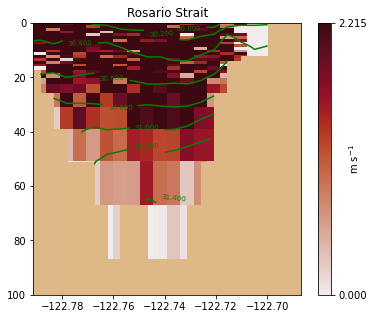

In [15]:
sp = speedCS(4, 286, 307, 266, 100, "Rosario Strait")

wooooo works! next step is to make a csv file of all the cross section grid size information because that part takes an aggressive amount of time to run. this is under the assumption that as long as the cross sections are the same in sections.txt/ segrid that the tranpsorts, depths, and lons arrays would be the same length. fingers crossed!

/home/rbeutel/anaconda3/envs/OceanParcels/lib/python3.8/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in true_divide
  hist /= s


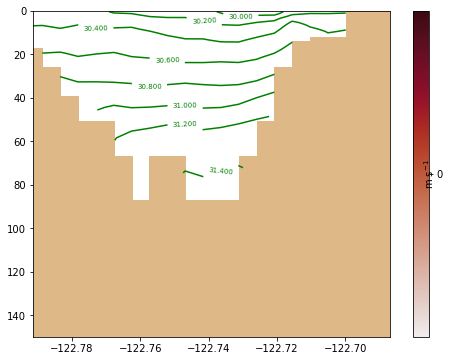

In [19]:
figrid = 266
igrid = figrid-1
fmask = mymesh.fmask[0, :, igrid]
tmask = mymesh.tmask[0]
nav_lon = mymesh.nav_lon[igrid]
u_lons = mymesh.glamv[0, igrid]    # note switch to v with the switch from t to f
f_lons = mymesh.glamf[0, igrid]
w_depths = mymesh.gdepw_1d


section = 4
m2lon = ((u_lons[307]-u_lons[286])/(mymesh.e2f[0, igrid, 286:307].sum()))
tmax = 1378670
vvmax = 0.15/float(m2lon)*24/tmax
xs, ys = np.meshgrid(np.array(mymesh.glamv[0, igrid]), np.array(mymesh.gdept_1d))
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

lons = mydata.init_lon[(mydata.final_section==section)]
depths = depthf(mydata.init_z[(mydata.final_section==section)]-1.)[0]
transports = mydata.init_transp[(mydata.final_section==section)]
vmax = vvmax*tmax/float(transports.sum())
c, xedge, yedge, im = ax.hist2d(lons, 
                                depths,
                                weights=transports,
                                bins=[np.array(f_lons[286:307]), w_depths[0]], cmap=cm.amp, 
                                     density=True, vmax=vmax)
pc = draw_patches(fmask, 286, 307, np.array(u_lons), np.array(w_depths[0]))
ax.add_collection(pc)
cb1 = fig.colorbar(im, ax=ax) 
cb1.set_ticks([0, vmax])
cb1.set_ticklabels([0, f'{vmax * float(m2lon) * float(transports.sum())/24.:.2f}'])
cb1.set_label('m s$^{-1}$', labelpad=-20)
salinity = 0.5*(np.ma.array(xr.open_dataset(salfile).vosaline[0, :, igrid],
                       mask=1-tmask[:, igrid]) +
                    np.ma.array(xr.open_dataset(salfile).vosaline[0, :, igrid+1],
                       mask=1-tmask[:, igrid+1]))
CS = ax.contour(xs, ys, salinity,  [29, 30, 30.2, 30.4, 30.6, 30.8, 31, 31.2, 31.4], colors='g')
ax.clabel(CS, inline=1, fontsize=7)
ax.invert_yaxis()
# ax.set_xlim((-123.32, -123.05))
ax.set_ylim((150, 0))
# ax.set_title("Day, September "+str(day+1))
mydata.close()

SO susan suggested looking back at her code and incluidng the norm step in the histogram in order to get the plot to do speeds not trnapsort without my complicated calc the speeds step. WHICH I'M PRETTY SURE i ignored before since it was giving me an error since the norm line is no longer a part of matplotlib. SO INSTEAD I DID DENSITY=TRUE which doesn't give me an error perceyyyyyyyyyyyyyy BUT does lead to the warning above (RuntimeWarning: invalid value encountered in true_divide hist /= s) and i'm not sure why <br>
at the moment i cant figure out what else is different with her code that would leadto this working for her and not me <br>
go back to old version of matplolib??? NO THERE MUST BE A BETTER WAY!